**Multi-Class Mental Health Text Classification using RoBERTa (PyTorch)
Dataset: Sentiment Analysis for Mental Health (Kaggle)
Task: Multi-class classification → Predict multiple mental health categories**

In [1]:
# ============================================================
# 1️⃣ Import Required Libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Combined Data.csv")
print("✅ Loaded dataset successfully!")
print("Shape:", df.shape)
print("\nStatus value counts:\n", df['status'].value_counts())

✅ Loaded dataset successfully!
Shape: (53043, 3)

Status value counts:
 status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [4]:
# Get all unique class names
class_names = df['status'].unique()
num_classes = len(class_names)

# Create mappings from class name to integer ID and back
class_to_id = {name: idx for idx, name in enumerate(class_names)}
id_to_class = {idx: name for idx, name in enumerate(class_names)}

In [5]:
print(f"✅ Found {num_classes} classes.")
print(f"Class mapping: {class_to_id}")

✅ Found 7 classes.
Class mapping: {'Anxiety': 0, 'Normal': 1, 'Depression': 2, 'Suicidal': 3, 'Stress': 4, 'Bipolar': 5, 'Personality disorder': 6}


In [6]:
# Convert string status to integer label
df['label'] = df['status'].map(class_to_id)

In [8]:
# Check label distribution
print("\nLabel distribution:\n", df['label'].value_counts())


Label distribution:
 label
1    16351
2    15404
3    10653
0     3888
5     2877
4     2669
6     1201
Name: count, dtype: int64


In [9]:
# Train-validation split (80-20)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['statement'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'] # Stratify will now work across all classes
)

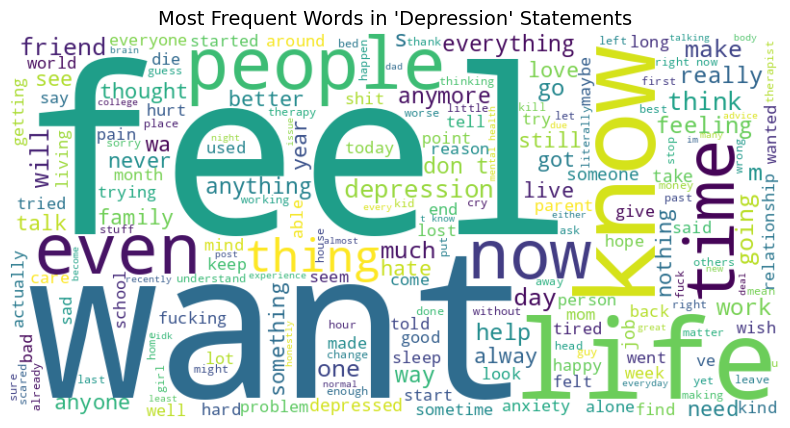

In [10]:
# ============================================================
# 4️⃣ Exploratory Data Analysis (EDA)
# ============================================================

# WordCloud for frequent words in 'Depression' texts (as an example)
text_example = " ".join(df[df['status'] == 'Depression']['statement'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_example)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in 'Depression' Statements", fontsize=14)
plt.show()

In [11]:
# ============================================================
# 5️⃣ Tokenization using RoBERTa
# ============================================================
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True)

class MentalHealthDataset(Dataset):
    """Custom Dataset for Mental Health Text Classification"""
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [12]:
train_dataset = MentalHealthDataset(train_texts, train_labels, tokenizer)
val_dataset = MentalHealthDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [13]:
# ============================================================
# 6️⃣ Model Setup (MODIFIED FOR MULTI-CLASS)
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use num_classes from Cell 3
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
model.to(device)

# Optimizer, Scheduler & Loss (No changes needed)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
# CrossEntropyLoss works for both binary and multi-class
criterion = nn.CrossEntropyLoss()

epochs = 6
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# ============================================================
# 7️⃣ Training Loop with Early Stopping (No changes needed)
# ============================================================
best_val_loss = np.inf
patience = 2
trigger_times = 0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # ---------------- Validation ----------------
    model.eval()
    val_loss, preds, true_labels = 0, [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(true_labels, preds)
    val_f1 = f1_score(true_labels, preds, average='weighted')

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Val F1:     {val_f1:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_roberta_model.pth")
        print("✅ Model saved!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⛔ Early stopping triggered!")
            break

print("\n🎯 Training Complete. Best model saved as best_roberta_model.pth")

Training Epoch 1/6: 100%|██████████| 5305/5305 [11:33<00:00,  7.65it/s]



Epoch 1/6
Train Loss: 0.7610
Val Loss:   0.5616
Val Acc:    0.7775
Val F1:     0.7746
✅ Model saved!


Training Epoch 2/6: 100%|██████████| 5305/5305 [11:16<00:00,  7.84it/s]



Epoch 2/6
Train Loss: 0.4935
Val Loss:   0.5632
Val Acc:    0.8026
Val F1:     0.8019


Training Epoch 3/6: 100%|██████████| 5305/5305 [11:14<00:00,  7.86it/s]



Epoch 3/6
Train Loss: 0.3896
Val Loss:   0.5226
Val Acc:    0.8086
Val F1:     0.8099
✅ Model saved!


Training Epoch 4/6: 100%|██████████| 5305/5305 [11:17<00:00,  7.83it/s]



Epoch 4/6
Train Loss: 0.3257
Val Loss:   0.7279
Val Acc:    0.8086
Val F1:     0.8079


Training Epoch 5/6: 100%|██████████| 5305/5305 [11:16<00:00,  7.84it/s]



Epoch 5/6
Train Loss: 0.2479
Val Loss:   0.9382
Val Acc:    0.8057
Val F1:     0.8061
⛔ Early stopping triggered!

🎯 Training Complete. Best model saved as best_roberta_model.pth


In [16]:
# ============================================================
# 8️⃣ Final Evaluation (MODIFIED FOR MULTI-CLASS)
# ============================================================
model.load_state_dict(torch.load("best_roberta_model.pth"))
model.eval()

# Create the target_names list from our id_to_class mapping
target_names = [id_to_class[i] for i in range(num_classes)]

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

print("\nFinal Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))
print("Final Accuracy:", accuracy_score(all_labels, all_preds))


Final Classification Report:

                      precision    recall  f1-score   support

             Anxiety       0.88      0.83      0.85       778
              Normal       0.97      0.95      0.96      3270
          Depression       0.78      0.71      0.74      3081
            Suicidal       0.66      0.76      0.71      2131
              Stress       0.70      0.71      0.71       534
             Bipolar       0.78      0.84      0.81       575
Personality disorder       0.66      0.69      0.67       240

            accuracy                           0.81     10609
           macro avg       0.78      0.78      0.78     10609
        weighted avg       0.81      0.81      0.81     10609

Final Accuracy: 0.8085587708549344


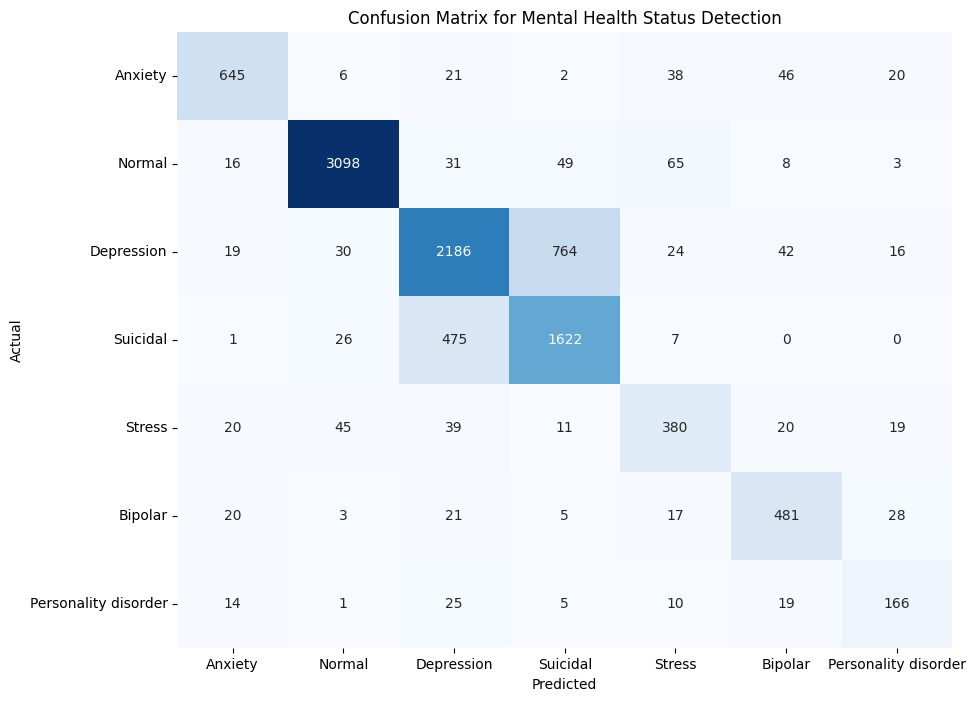

In [17]:
# ============================================================
# 9️⃣ Visualization of Results (MODIFIED FOR MULTI-CLASS)
# ============================================================

# Use the same target_names list
target_names = [id_to_class[i] for i in range(num_classes)]

plt.figure(figsize=(10,8)) # Made figure larger for more classes
sns.heatmap(
    pd.crosstab(np.array(all_labels), np.array(all_preds)),
    annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Mental Health Status Detection")
plt.show()